In [1]:
import sys
import pandas as pd
from importlib import reload
import numpy as np
sys.path += ["../src"]
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import subplots as sbp
from glob import glob
import warnings
from IPython.display import display, Latex
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter, FormatStrFormatter
warnings.simplefilter(action='ignore', category=FutureWarning)
from itertools import combinations


In [2]:
import inference_isbackfire
import BC_update

/home/jacopo.lenti/miniconda3/envs/lotm_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
reload(inference_isbackfire)

<module 'inference_isbackfire' from '/home/jacopo.lenti/LOTM/notebooks/../src/inference_isbackfire.py'>

In [4]:
sns.set_palette([sns.color_palette("colorblind")[k] for k in [-1,4,2,3]])
sns.color_palette()

[(0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0)]

In [5]:
methods = ["svinormal", "sviNF", "mcmc", "abc"]
convert_to_exp = lambda l: [fr"$10^{u}$" if u >= 0 else fr"$0$" for u in l]

In [6]:
path =  "../data/isback*20/est*"
df =  pd.concat([pd.DataFrame(pd.read_pickle(file)) for file in glob(path)]).sort_values("method", ascending = False).assign(rep = lambda x: [u.split("_")[0] for u in x["id"]])

In [7]:
df.groupby(["N","T", "mu_plus"]).count()["id"].unstack()

mu_plus   0.01  0.03  0.05  0.07  0.09  0.11  0.13  0.15  0.17  0.19
N   T                                                               
50  128    NaN   8.0   NaN   4.0   8.0  11.0  15.0  11.0  11.0   8.0
    512    8.0  12.0   8.0  11.0  16.0   4.0   7.0   4.0   8.0   NaN
    2048   4.0  15.0  14.0   NaN  12.0  11.0   7.0   NaN   7.0   4.0
    8192   NaN   4.0  10.0   4.0  16.0   NaN   3.0  14.0  18.0   4.0
100 128    8.0   4.0  12.0   8.0   8.0   4.0   8.0  12.0   4.0  12.0
    512    4.0   NaN  24.0   8.0   NaN  16.0   7.0   8.0   4.0   8.0
    2048   7.0   4.0   6.0   NaN   4.0  23.0   8.0   NaN  10.0  11.0
    8192   7.0   7.0  11.0  15.0  19.0   4.0   4.0   NaN   4.0   3.0
200 128    8.0  12.0   4.0  16.0  20.0   4.0   4.0   NaN   8.0   4.0
    512   28.0   8.0   4.0   7.0   3.0   4.0   8.0   4.0   3.0   8.0
    2048  12.0  12.0   4.0   NaN   4.0   7.0   4.0  11.0  11.0  12.0
    8192   8.0   NaN  16.0   7.0  10.0  19.0   3.0   4.0   7.0   NaN
400 128   16.0   4.0  12.0   NaN   NaN  16.0   8.0   NaN  24.0   NaN
    512    NaN  12.0   8.0  16.0   NaN   8.0  16.0   4.0   4.0  12.0
    2048   4.0   NaN  16.0   8.0   8.0   4.0   4.0   8.0  22.0   3.0
    8192   7.0   4.0   7.0   7.0   4.0   8.0  12.0   3.0  11.0  11.0

In [8]:
full_id = list(df["id"].value_counts().reset_index().query("count == 4")["id"])
ids_methods = {method: list(df.query("method == @method")["id"]) for method in methods}

print("Total number of combinations", len(df.query("(method == 'svinormal')&(rep == '1')")))
print("Total number of experiments", len(df.query("(method == 'svinormal')&(rep == '1')")) * 3 * 4)
print("Total number of completed experiments", len(df))
print("Experiments completed with all the methods", len(full_id))

Total number of combinations 16
Total number of experiments 192
Total number of completed experiments 1226
Experiments completed with all the methods 266


In [9]:
df["error_backfire"] = df["round_backfire"] == df["is_backfire"]
df["distance_backfire"] = np.abs(df["backfire_mean"] - df["is_backfire"])
df.columns

Index(['id', 'mse_epsilon', 'tot_time', 'n_steps', 'n_samples', 'method',
       'n_simulations', 'mu_plus', 'mu_minus', 'is_backfire', 'round_backfire',
       'backfire_mean', 'backfire_std', 'epsilon_plus_error',
       'epsilon_minus_error', 'epsilon_plus_mean', 'epsilon_minus_mean',
       'epsilon_plus_std', 'epsilon_minus_std', 'epsilon_plus_real',
       'epsilon_minus_real', 'pos_interactions_plus', 'pos_interactions_minus',
       'tot_interactions', 'T', 'N', 'edge_per_t', 'var_X_end', 'skew_X_end',
       'kurtosis_X_end', 'bimodality_X_end', 'rep', 'error_backfire',
       'distance_backfire'],
      dtype='object')

In [10]:
epsilons = ["epsilon_plus", "epsilon_minus"]
methods_names = ["SVI - Normal", "SVI - NF", "MCMC", "ABC"]
patches_methods = [mpatches.Patch(color = sns.color_palette()[j], label = method) for j,method in enumerate(methods_names)]
y_vars = ["distance_backfire", "mse_epsilon"]
signs = ["plus", "minus"]

df["n_iter"] = df.fillna(0)["n_steps"] + df.fillna(0)["n_samples"]
df["rmse_epsilon"] = df["mse_epsilon"] ** (0.5)
df["interaction_per_person"] = df["T"] * df["edge_per_t"] / df["N"]
df["pos_interactions"] = df["pos_interactions_plus"] + df["pos_interactions_minus"]


In [11]:
vars = {type_var: [u for u in df.columns if type_var in u] for type_var in ["std", "error", "mean", "real", "X", "interaction"]}

In [12]:
dfs = {method: df.query("method == @method").reset_index().drop("index", axis = 1) for method in methods}

In [13]:
dfs["svinormal"].columns

Index(['id', 'mse_epsilon', 'tot_time', 'n_steps', 'n_samples', 'method',
       'n_simulations', 'mu_plus', 'mu_minus', 'is_backfire', 'round_backfire',
       'backfire_mean', 'backfire_std', 'epsilon_plus_error',
       'epsilon_minus_error', 'epsilon_plus_mean', 'epsilon_minus_mean',
       'epsilon_plus_std', 'epsilon_minus_std', 'epsilon_plus_real',
       'epsilon_minus_real', 'pos_interactions_plus', 'pos_interactions_minus',
       'tot_interactions', 'T', 'N', 'edge_per_t', 'var_X_end', 'skew_X_end',
       'kurtosis_X_end', 'bimodality_X_end', 'rep', 'error_backfire',
       'distance_backfire', 'n_iter', 'rmse_epsilon', 'interaction_per_person',
       'pos_interactions'],
      dtype='object')

### Paper plots

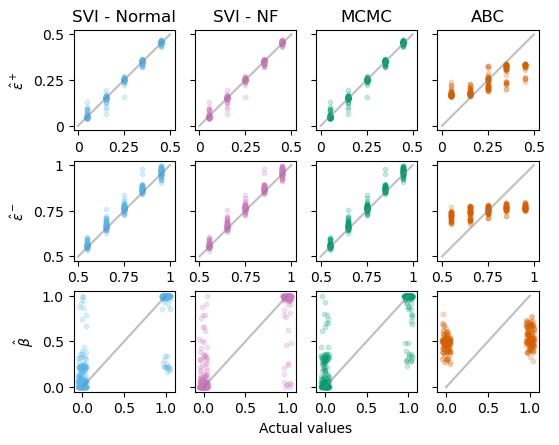

In [15]:
fig, axes = sbp(ncols = 4, nrows = 3, figsize = (6, 4.7), sharey = "row")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace = 0.2, hspace = 0.3)

xs = [epsilon + "_real" for epsilon in epsilons] + ["is_backfire"]
ys = [epsilon + "_mean" for epsilon in epsilons] + ["backfire_mean"]
ax_lims = [(0,0.5), (0.5,1.), (0., 1.)]
ax_ticks = [(0,0.25,0.5), (0.5,0.75,1), (0., .5, 1.)]
for i, var_str in enumerate([r"$\hat{\epsilon}^+$", r"$\hat{\epsilon}^-$", r"$\hat{\beta}$"]):
    for j,method in enumerate(methods):
        axes[i,j].plot(ax_lims[i], ax_lims[i], color = "grey", alpha = 0.5)
        sns.regplot(dfs[method], x = xs[i], y = ys[i], ax = axes[i,j], color = sns.color_palette()[j],fit_reg = False, 
                    x_jitter = 0.05 * (i == 2), scatter_kws = {"alpha": 0.2, "s": 10})
        # axes[i,j].set_xlim(ax_lims[i])
        # axes[i,j].set_ylim(ax_lims[i])
            
        axes[0,j].set_title(["SVI - Normal", "SVI - NF", "MCMC", "ABC"][j])
        # axes[i,j].set_xlabel(r"Real $\epsilon$" +  var_str)
        axes[i,j].set_xlabel("")
        axes[i,j].set_ylabel("")
        axes[i,j].set_xticks(ax_ticks[i], [str(u) for u in ax_ticks[i]])
        axes[i,j].set_yticks(ax_ticks[i], [str(u) for u in ax_ticks[i]])
        if i == 20:
            axes[i,j].set_xscale("log")
            axes[i,j].set_yscale("log")
        # axes[i,j].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        # axes[i,j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # axes[i,0].set_ylabel(r"Estimated $\epsilon$" + var_str)
    axes[i,0].set_ylabel(var_str)
    # axes[i,0].set_ylabel(r"$\hat{\epsilon}$" + var_str)
           
axes[2,0].legend(loc='upper center', bbox_to_anchor=(2.3, -0.43), fancybox=True, ncol=4, handles = patches_methods)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Actual values")

# fig.savefig(f"../paper/BCMU_scatterplot_extended_bottomlegend.pdf", bbox_inches="tight")

axes[2,0].get_legend().remove()
fig.savefig(f"../paper/BCMU_scatterplot_extended_nolegend.pdf", bbox_inches="tight")
fig.show()


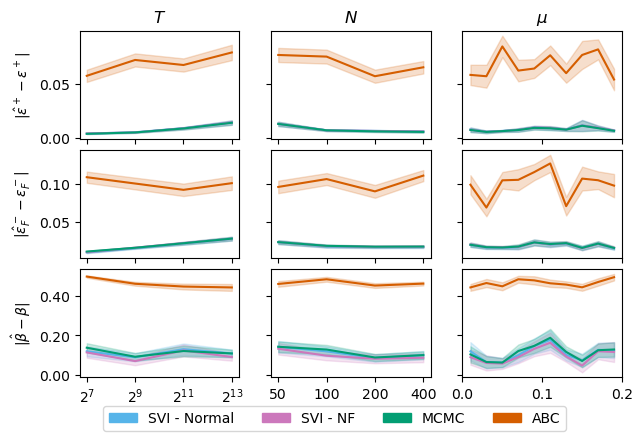

In [14]:
fig, axes = sbp(ncols = 3, nrows = 3, figsize = (7,4.5), sharey = "row", sharex = "col")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace = 0.2, hspace = 0.1)

x_lab_T = [128, 512, 2048, 8192]
x_labT_pow2 =  [r"$2^{7}$", r"$2^{9}$", r"$2^{11}$", r"$2^{13}$"]
x_lab_N = [50, 100, 200, 400]
x_lab_mu = np.arange(0., 0.21, 0.1)

for i, y_var in enumerate(['epsilon_plus_error', 'epsilon_minus_error', 'distance_backfire']):
    for j, x_var in enumerate(["T", "N", "mu_plus"]):
        # for method in methods:
            # sns.lineplot(data = dfs[method], x = x_var, y = y_var, ax = axes[i,j], errorbar = "se")
        # sns.lineplot(data = df, x = x_var, y = y_var, hue = "method", ax = axes[i,j], errorbar = "se", palette = colors)
        sns.lineplot(data = df, x = x_var, y = y_var, hue = "method", ax = axes[i,j], errorbar = "se")
        axes[0,j].set_title([r"$T$", r"$N$", r"$\mu$"][j])
        # axes[i,j].set_yscale("log")
        # axes[i,j].set_xticklabels([])
        if j < 2:
            axes[i,j].set_xscale("log")

        axes[i,j].tick_params(axis = u'both', which = 'minor', length=0)
        axes[i,j].xaxis.set_minor_locator(plt.NullLocator())
        axes[i,j].set_xlabel("")
        axes[i,j].set_xticks([x_lab_T, x_lab_N, x_lab_mu][j], 
                             [x_labT_pow2, x_lab_N, x_lab_mu][j])
        axes[i,j].get_legend().remove()
        if j < 2:   
            axes[i,j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        if j == 2:
            axes[i,j].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
    axes[i,0].set_ylabel([r"$| \hat{\epsilon}^+ - \epsilon^+ |$", r"$| \hat{\epsilon}^-_F - \epsilon^-_F |$",
                          r"$| \hat{\beta} - \beta|$"][i])
    axes[i,1].set_ylabel("")
    
        
axes[2,0].legend(loc='upper center', bbox_to_anchor=(1.6, -0.2), fancybox=True, ncol=4, handles = patches_methods, fontsize = 10)
fig.savefig(f"../paper/BCMU_lineplot_extended_bottomlegend.pdf", bbox_inches="tight")

# axes[2,0].get_legend().remove()
# axes[0,0].legend(loc='upper center', bbox_to_anchor=(1., 1.45), fancybox=True, ncol=4, handles = patches_methods, fontsize = 10)
# fig.savefig(f"../paper/lineplot_extended_toplegend.pdf", bbox_inches="tight")

# axes[0,0].get_legend().remove()
# fig.savefig(f"../paper/lineplot_extended_nolegend.pdf", bbox_inches="tight")
fig.show()

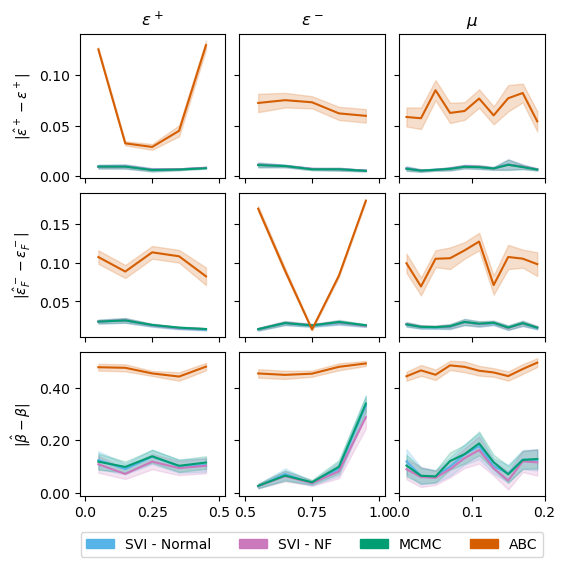

In [18]:
fig, axes = sbp(ncols = 3, nrows = 3, figsize = (6,6), sharey = "row", sharex = "col")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace = 0.1, hspace = 0.1)

x_lab_epsilon_plus = np.arange(0., 0.51, 0.25)
x_lab_epsilon_minus = np.arange(0.5, 1.1, 0.25)
x_ticks_eplus = [FormatStrFormatter("%.1f")(0.), FormatStrFormatter("%.2f")(0.25), FormatStrFormatter("%.1f")(.5),]
x_ticks_eminus = [FormatStrFormatter("%.1f")(0.5), FormatStrFormatter("%.2f")(0.75), FormatStrFormatter("%.1f")(1.),]
x_lab_mu = np.arange(0., 0.21, 0.1)

for i, y_var in enumerate(['epsilon_plus_error', 'epsilon_minus_error', 'distance_backfire']):
    for j, x_var in enumerate(["epsilon_plus_real", "epsilon_minus_real", "mu_plus"]):
        # for method in methods:
            # sns.lineplot(data = dfs[method], x = x_var, y = y_var, ax = axes[i,j], errorbar = "se")
        # sns.lineplot(data = df, x = x_var, y = y_var, hue = "method", ax = axes[i,j], errorbar = "se", palette = colors)
        sns.lineplot(data = df, x = x_var, y = y_var, hue = "method", ax = axes[i,j], errorbar = "se")
        axes[0,j].set_title([r"$\epsilon^+$", r"$\epsilon^-$", r"$\mu$"][j])
        
        axes[i,j].tick_params(axis = u'both', which = 'minor', length=0)
        axes[i,j].xaxis.set_minor_locator(plt.NullLocator())
        axes[i,j].set_xlabel("")
        axes[i,j].set_xticks([x_lab_epsilon_plus, x_lab_epsilon_minus, x_lab_mu][j])
        axes[i,j].get_legend().remove()
        if j < 2:   
            axes[i,j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        if j == 2:
            axes[i,j].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
    axes[i,0].set_xlim([-0.02,0.52])
    axes[i,1].set_xlim([0.48, 1.02])
    axes[i,0].set_ylabel([r"$| \hat{\epsilon}^+ - \epsilon^+ |$", r"$| \hat{\epsilon}^-_F - \epsilon^-_F |$",
                          r"$| \hat{\beta} - \beta|$"][i])
    axes[i,1].set_ylabel("")
axes[2,0].set_xticklabels(x_ticks_eplus)
axes[2,1].set_xticklabels(x_ticks_eminus)


        
axes[2,0].legend(loc='upper center', bbox_to_anchor=(1.6, -0.2), fancybox=True, ncol=4, handles = patches_methods, fontsize = 10)
fig.savefig(f"../paper/BCMU_lineplot_extended_bottomlegend.pdf", bbox_inches="tight")

# axes[2,0].get_legend().remove()
# axes[0,0].legend(loc='upper center', bbox_to_anchor=(1., 1.45), fancybox=True, ncol=4, handles = patches_methods, fontsize = 10)
# fig.savefig(f"../paper/lineplot_extended_toplegend.pdf", bbox_inches="tight")

# axes[0,0].get_legend().remove()
# fig.savefig(f"../paper/lineplot_extended_nolegend.pdf", bbox_inches="tight")
fig.show()

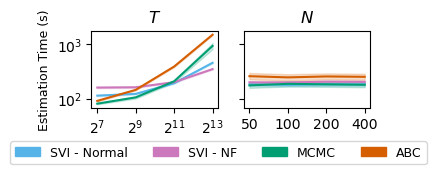

In [36]:
fig, axes = sbp(ncols = 2, nrows = 1, figsize = (3.6,1), sharey = "row", sharex = "col")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace = 0.2, hspace = 0.1)

x_lab_T = [128, 512, 2048, 8192]
x_labT_pow2 =  [r"$2^{7}$", r"$2^{9}$", r"$2^{11}$", r"$2^{13}$"]
x_lab_N = [50, 100, 200, 400]

y_var = "tot_time"
for j, x_var in enumerate(["T", "N"]):
    # for method in methods:
    #     sns.lineplot(data = dfs[method], x = x_var, y = y_var, ax = axes[j], errorbar = "se")
    sns.lineplot(data = df, x = x_var, y = y_var, ax = axes[j], hue = "method", errorbar = "se")
    axes[j].set_title([r"$T$", r"$N$"][j])
    axes[j].set_xscale("log")
    axes[j].set_yscale("log")

    axes[j].tick_params(axis = u'both', which = 'minor', length=0)
    axes[j].xaxis.set_minor_locator(plt.NullLocator())
    axes[j].set_xlabel("")
    axes[j].set_xticks([x_lab_T, x_lab_N][j], 
                         [x_labT_pow2, x_lab_N][j])
    axes[j].get_legend().remove()
    
        
axes[0].set_ylabel("Estimation Time (s)", fontsize = 9)
axes[1].set_ylabel("")

# axes[1].legend(loc='upper center', bbox_to_anchor=(1.8, 1.1), fancybox=True, ncol=1, handles = patches_methods, fontsize = 12)
# fig.savefig(f"../paper/lineplot_estimation_time_rightlegend.pdf", bbox_inches="tight")

# axes[1].get_legend().remove()
axes[0].legend(loc='upper center', bbox_to_anchor=(1, -0.35), fancybox=True, ncol=4, handles = patches_methods, fontsize = 9)
fig.savefig(f"../paper/BCMU_lineplot_estimation_time_bottomlegend.pdf", bbox_inches="tight")

# axes[0].get_legend().remove()
# fig.savefig(f"../paper/lineplot_estimation_time_nolegend.pdf", bbox_inches="tight")
fig.show()

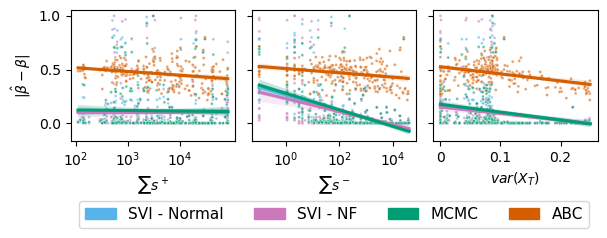

In [20]:
fig, axes = sbp(ncols = 3, nrows = 1, figsize = (6.8,1.7), sharey = "row", sharex = "col")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace = 0.1, hspace = 0.)

x_vars = ['pos_interactions_plus', 'pos_interactions_minus', "var_X_end"]
y_var = "rmse_epsilon"
y_lim = [-2.7, -0.5]

y_var = "distance_backfire"
y_lim = [0., 1.]

# x_ticks_exp = [[10**3,10**4,10**5], [10**3,10**4,10**5], [0,0.1,0.2]]
x_ticks_exp = [[2,3,4], [0,2,4], [0,0.1,0.2]]
# y_ticks_exp = [-1, -2]

for j, x_var in enumerate(x_vars):
    sns.scatterplot(data = df.assign(
            rmse_epsilon = lambda x:np.log10(x["rmse_epsilon"] + 0.0001),
            pos_interactions_plus = lambda x:np.log10(x["pos_interactions_plus"] + 0.1),
            pos_interactions_minus = lambda x:np.log10(x["pos_interactions_minus"] + 0.1),
            ),
            x = x_var, y = y_var, ax = axes[j], marker = ".", size = 0.05, alpha = 0.6, hue = "method")
    for k,method in enumerate(methods):
        sns.regplot(data = df.assign(
            pos_interactions_plus = lambda x:np.log10(x["pos_interactions_plus"] + 0.1),
            pos_interactions_minus = lambda x:np.log10(x["pos_interactions_minus"] + 0.1),
            rmse_epsilon = lambda x:np.log10(x["rmse_epsilon"] + 0.)).query("method == @method"),
            x = x_var, y = y_var, ax = axes[j], color = sns.color_palette()[k], scatter_kws = {'s': 0})
    axes[j].set_xticks(x_ticks_exp[j], convert_to_exp(x_ticks_exp[j]) if j < 2 else x_ticks_exp[j])
    
    # axes[j].set_yticks(y_ticks_exp, [r"$10^{-1}$", r"$10^{-2}$"])
    axes[j].set_ylabel("")
    axes[j].set_xlabel("")
    # axes[j].set_ylim(y_lim)
    axes[j].set_xlabel([r"$\sum s^+$", r"$\sum s^-$", r"$var(X_T)$"][j])
    axes[0].set_ylabel(r"$RMSE(\hat{\epsilon}^+, \hat{\epsilon}^-)$")
    axes[0].set_ylabel(r"$| \hat{\beta} - \beta |$")
    
    axes[j].get_legend().remove()
    
axes[2].legend(loc='upper center', bbox_to_anchor=(1.5, 1), fancybox=True, ncol=1, handles = patches_methods, fontsize = 10)
# fig.savefig(f"../paper/regplot_rmse_rightlegend.pdf", bbox_inches="tight")

axes[2].get_legend().remove()
axes[0].legend(loc='upper center', bbox_to_anchor=(1.6, -0.4), fancybox=True, ncol=4, handles = patches_methods, fontsize = 11)
fig.savefig(f"../paper/BCMU_regplot_rmse_bottomlegend.pdf", bbox_inches="tight")

# axes[0].get_legend().remove()
# fig.savefig(f"../paper/regplot_rmse_nolegend.pdf", bbox_inches="tight")
fig.show()

### Quantitative Results

In [21]:
for method in methods:
    print(f"Average RMSE {method} {df.query('(method == @method)')['rmse_epsilon'].mean()}")

print("")

for method in methods:
    print(f"Average RMSE intersection {method} {df.query('(method == @method)&(id in @full_id)')['rmse_epsilon'].mean()}")

print("")
for method in methods:
    print(f"Average distance backfire {method} {df.query('(method == @method)')['distance_backfire'].mean()}")
print("")
for method in methods:
    print(f"Proportion correct backfire {method} {df.query('(method == @method)')['error_backfire'].mean()}")
print("")

print("")
method = "sviNF"
print(f"Average distance backfire F with filter A {df.query('(method == @method)&(pos_interactions > 10)')['distance_backfire'].mean()}")
print(f"Average distance backfire F with filter B {df.query('(method == @method)&(pos_interactions > 10)&(var_X_end > 0.1)')['distance_backfire'].mean()}")
print(f"Average RMSE epsilon F with filter A {df.query('(method == @method)&(pos_interactions > 10)')['rmse_epsilon'].mean()}")
print(f"Average RMSE epsilon F with filter B {df.query('(method == @method)&(pos_interactions > 10)&(var_X_end > 0.1)')['rmse_epsilon'].mean()}")
print("")
for method in methods:
    print(f"Average estimation time {method} {df.query('(id in @full_id)&(method == @method)')['tot_time'].mean()}")
print("")
method0 = "svinormal"
for method in methods:
    print(f"Average estimation time vs svinormal estimation time {method} {df.query('(id in @full_id)&(method == @method)')['tot_time'].mean() / df.query('(id in @full_id)&(method == @method0)')['tot_time'].mean()}")
print("")
method0 = "sviNF"
for method in methods:
    id_inters = set(ids_methods[method]) & set(ids_methods[method0])
    print(f"Average RMSE vs svinNF RMSE {method} {df.query('(id in @id_inters)&(method == @method)')['rmse_epsilon'].mean() / df.query('(id in @id_inters)&(method == @method0)')['rmse_epsilon'].mean()}")
print("")
for method in methods:
    id_inters = set(ids_methods[method]) & set(ids_methods[method0])
    print(f"Average improvement RMSE vs svinNF RMSE {method} {1 - df.query('(id in @id_inters)&(method == @method0)')['rmse_epsilon'].mean() / df.query('(id in @id_inters)&(method == @method)')['rmse_epsilon'].mean()}")
print("")
print(f"Average time biggest experiments {df.query('(N == 400)&(T == 8192)')['tot_time'].mean()}")



Average RMSE svinormal 0.01567663530612929
Average RMSE sviNF 0.01594266800187056
Average RMSE mcmc 0.015972621278076714
Average RMSE abc 0.096159135178861

Average RMSE intersection svinormal 0.015730577667595527
Average RMSE intersection sviNF 0.015993935950635602
Average RMSE intersection mcmc 0.0160840783913694
Average RMSE intersection abc 0.096159135178861

Average distance backfire svinormal 0.11214145524834862
Average distance backfire sviNF 0.09987022454314647
Average distance backfire mcmc 0.11509680249008625
Average distance backfire abc 0.46499623918443694

Proportion correct backfire svinormal 0.928125
Proportion correct backfire sviNF 0.925
Proportion correct backfire mcmc 0.928125
Proportion correct backfire abc 0.6428571428571429


Average distance backfire F with filter A 0.09987022454314647
Average distance backfire F with filter B 0.014616500763666062
Average RMSE epsilon F with filter A 0.01594266800187056
Average RMSE epsilon F with filter B 0.01989453507397098

Av

In [20]:
id_inters = set(ids_methods[method]) & set(ids_methods[method0])
method0 = "sviNF"

dict_results = {
    "Average RMSE": [df.query('(method == @method)')['rmse_epsilon'].mean() for method in methods],
    "Average RMSE intersection": [df.query('(method == @method)&(id in @full_id)')['rmse_epsilon'].mean() for method in methods],
    "Average distance backfire": [df.query('(method == @method)')['distance_backfire'].mean() for method in methods],
    "Proportion correct backfire": [df.query('(method == @method)')['error_backfire'].mean() for method in methods],
    "Average distance backfire F with filter A": [df.query('(method == @method)&(pos_interactions > 10)')['distance_backfire'].mean() for method in methods],
    "Average distance backfire F with filter B": [df.query('(method == @method)&(pos_interactions > 10)&(var_X_end > 0.1)')['distance_backfire'].mean() for method in methods],
    "Average RMSE epsilon F with filter A": [df.query('(method == @method)&(pos_interactions > 10)')['rmse_epsilon'].mean() for method in methods],
    "Average RMSE epsilon F with filter B": [df.query('(method == @method)&(pos_interactions > 10)&(var_X_end > 0.1)')['rmse_epsilon'].mean() for method in methods],
    "Average estimation time": [df.query('(id in @full_id)&(method == @method)')['tot_time'].mean() for method in methods],
    "Average estimation time vs svinormal estimation time": [df.query('(id in @full_id)&(method == @method)')['tot_time'].mean() / df.query('(id in @full_id)&(method == @method0)')['tot_time'].mean() for method in methods],
    "Average RMSE vs svinNF RMSE": [df.query('(id in @id_inters)&(method == @method)')['rmse_epsilon'].mean() / df.query('(id in @id_inters)&(method == @method0)')['rmse_epsilon'].mean() for method in methods],
    "Average improvement RMSE vs svinNF RMSE": [1 - df.query('(id in @id_inters)&(method == @method0)')['rmse_epsilon'].mean() / df.query('(id in @id_inters)&(method == @method)')['rmse_epsilon'].mean() for method in methods],
}

In [23]:
pd.DataFrame(dict_results, index = methods).T

,svinormal,sviNF,mcmc,abc
Average RMSE,0.015677,0.015943,0.015973,0.096159
Average RMSE intersection,0.015731,0.015994,0.016084,0.096159
Average distance backfire,0.112141,0.099870,0.115097,0.464996
Proportion correct backfire,0.928125,0.925000,0.928125,0.642857
Average distance backfire F with filter A,0.112141,0.099870,0.115097,0.464996
Average distance backfire F with filter B,0.012878,0.014617,0.013320,0.395816
Average RMSE epsilon F with filter A,0.015677,0.015943,0.015973,0.096159
Average RMSE epsilon F with filter B,0.019482,0.019895,0.019554,0.095094
Average estimation time,206.478729,210.170648,244.463058,468.034560
Average estimation time vs svinormal estimation time,0.982434,1.000000,1.163165,2.226926


### Latex Macros

In [32]:
for method in methods:
    print(rf"\URMSE{method}", df.query('(method == @method)')['rmse_epsilon'].mean())

print("")

for method in methods:
    print(rf"\URMSEintersection{method}", df.query('(method == @method)&(id in @full_id)')['rmse_epsilon'].mean())

print("")
for method in methods:
    print(rf"\Ubeta{method}", df.query('(method == @method)')['distance_backfire'].mean())
print("")
for method in methods:
    print(rf"\Uapproxbeta{method}", df.query('(method == @method)')['error_backfire'].mean())
print("")
# for method in methods:
#     print(f"Average  error F {method} {df.query('(method == @method)')['abs_error_f'].mean()}")
# print("")

print("")
# method = "sviNF"
# print(f"Average relative error F with filter A {df.query('(method == @method)&(pos_interactions > 10)')['rel_error_f'].mean()}")
# print(f"Average relative error F with filter B {df.query('(method == @method)&(pos_interactions > 10)&(var_X_end > 0.1)')['rel_error_f'].mean()}")
# print(f"Average RMSE epsilon F with filter A {df.query('(method == @method)&(pos_interactions > 10)')['rmse_epsilon'].mean()}")
# print(f"Average RMSE epsilon F with filter B {df.query('(method == @method)&(pos_interactions > 10)&(var_X_end > 0.1)')['rmse_epsilon'].mean()}")
# print("")
# for method in methods:
#     print(f"Average estimation time {method} {df.query('(id in @full_id)&(method == @method)')['tot_time'].mean()}")
print("")
method0 = "svinormal"
for method in methods:
    print(rf"\Utime{method}vssvinormal", df.query('(id in @full_id)&(method == @method)')['tot_time'].mean() / df.query('(id in @full_id)&(method == @method0)')['tot_time'].mean())
print("")
method0 = "svinormal"
for method in methods:
    id_inters = set(ids_methods[method]) & set(ids_methods[method0])
    print(rf"\URMSE{method}vs{method0}", df.query('(id in @id_inters)&(method == @method)')['rmse_epsilon'].mean() / df.query('(id in @id_inters)&(method == @method0)')['rmse_epsilon'].mean())
print("")
# for method in methods:
#     id_inters = set(ids_methods[method]) & set(ids_methods[method0])
#     print(f"Average improvement RMSE vs svinNF RMSE {method} {1 - df.query('(id in @id_inters)&(method == @method0)')['rmse_epsilon'].mean() / df.query('(id in @id_inters)&(method == @method)')['rmse_epsilon'].mean()}")
# print("")
# print(f"Average time biggest experiments {df.query('(max_f_possible == 80)&(T == 8192)')['tot_time'].mean()}")



\URMSEsvinormal 0.01567663530612929
\URMSEsviNF 0.01594266800187056
\URMSEmcmc 0.015972621278076714
\URMSEabc 0.096159135178861

\URMSEintersectionsvinormal 0.015730577667595527
\URMSEintersectionsviNF 0.015993935950635602
\URMSEintersectionmcmc 0.0160840783913694
\URMSEintersectionabc 0.096159135178861

\Ubetasvinormal 0.11214145524834862
\UbetasviNF 0.09987022454314647
\Ubetamcmc 0.11509680249008625
\Ubetaabc 0.46499623918443694

\Uapproxbetasvinormal 0.928125
\UapproxbetasviNF 0.925
\Uapproxbetamcmc 0.928125
\Uapproxbetaabc 0.6428571428571429



\Utimesvinormalvssvinormal 1.0
\UtimesviNFvssvinormal 1.017880381372942
\Utimemcmcvssvinormal 1.1839624273125078
\Utimeabcvssvinormal 2.266744672670501

\URMSEsvinormalvssvinormal 1.0
\URMSEsviNFvssvinormal 1.0169700124131391
\URMSEmcmcvssvinormal 1.0188807078921902
\URMSEabcvssvinormal 6.11288009956212

